# Capstone Project - Toronto neighborhoods
Added coordinates for neighborhoods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import geocoder 
import folium

from sklearn.cluster import KMeans 
from sklearn import preprocessing

%matplotlib inline 

Read the website into a "soup" using BeautifulSoup 

In [2]:
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get(url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
content = driver.page_source
soup = BeautifulSoup(content)


Looking for [chromedriver 80.0.3987.106 win32] driver in cache 
File found in cache by path [C:\Users\Amritha PC\.wdm\drivers\chromedriver\80.0.3987.106\win32\chromedriver.exe]


Extract data from the website

In [3]:
# get contents of webpage
table = soup.find('table')

# extract table headers
table_cols = table.find_all('th')
labels=[i.text.strip('\n') for i in table_cols]
#print(labels)

table_rows = table.find_all('tr')
data = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text.strip('\n') for i in td]
    if len(row)>0:
        #print(row)
        data.append(row)   

### Write data into a pandas dataframe and apply preprocessing (remove invalid rows)

In [4]:
# write into a df
df = pd.DataFrame(columns=labels, data=np.array(data).reshape(len(data),-1))
df = df[df['Borough'] != 'Not assigned']
df = df.reset_index(drop=True)
#df = df[df['Neighborhood'] != '']
df.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


### Get co-ordinates using the supplied excel file as geocoding is unreliable
First, read the coordinates

In [5]:
coord = pd.read_csv("Geospatial_coordinates.csv")
coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Get list of postal codes,and find corresponding coordinates

In [6]:
p_code = df['Postal code'].tolist()

lat = []
long = []
for p in p_code:
    lat.append(coord[coord['Postal Code']==p]['Latitude'].values[0])
    long.append(coord[coord['Postal Code']==p]['Longitude'].values[0])

Add latitudes and longitudes to the dataframe

In [7]:
df['Latitude'] = lat 
df['Longitude'] = long 
df

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North,43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,Business reply mail Processing CentrE,43.662744,-79.321558
101,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...,43.636258,-79.498509


### Explore the data by plotting

Note that foursquare is not used for exploration as it means, I will have to upload client_id, client_secret_id on Github. Since this is not ideal, that option is not considered.

For privacy reasons, foursquare is not used. 

I will be using euclidean distance metrics to clasify the neighborhoods. The plan is to classify the neighborhoods and see if neightboords end up being classified based on buroughs or even groups of buroughs.

In [8]:
g = geocoder.osm('Toronto, Ontario')
latitude = g.latlng[0]
longitude = g.latlng[1]

# create map of Manhattan using latitude and longitude values
toronto_map = folium.Map(location=[latitude+0.05, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

## Kmeans Clustering

An immediate observation from the above plot is that the density of neighborhoods is not uniform. k-means has issues classifying clusters that do not have uniform density. DBscan/OPTICS, might be more preferrred.

First format/preprocess data

In [13]:
X = df[['Latitude','Longitude']]
y = df['Borough']

Since we are using k-means, the next step is to find the number of clusters.

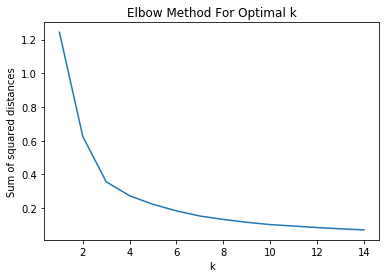

In [14]:
sum_sq_dist = []
k_range = range(1,15)
for k in k_range:
    kM = KMeans(n_clusters=k, random_state=0)
    y_pred = kM.fit_predict(X)
    sum_sq_dist.append(kM.inertia_)
plt.plot(k_range,sum_sq_dist)
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Based on the above plot, we choose k as 3

In [15]:
kM = KMeans(n_clusters=3, random_state=0)
y_pred = kM.fit_predict(X)

df['Cluster number'] = y_pred
df

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster number
0,M3A,North York,Parkwoods,43.753259,-79.329656,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,0
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,2
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763,1
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,2
...,...,...,...,...,...,...
98,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North,43.653654,-79.506944,1
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,2
100,M7Y,East Toronto,Business reply mail Processing CentrE,43.662744,-79.321558,2
101,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...,43.636258,-79.498509,1


In [44]:
# create map
map_clusters = folium.Map(location=[latitude+0.05, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Cluster number']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Boroughs and neighborhoods in the first cluster

In [16]:
borough = df[df['Cluster number'] == 0]
print('Boroughs in cluster 0:')
print(set(borough['Borough'].tolist()))

print()
nbrhd = df[df['Cluster number'] == 0]
print('Neighborhoods in cluster 0:')
print(set(nbrhd['Neighborhood'].tolist()))

Boroughs in cluster 0:
{'North York', 'Scarborough', 'East York', 'East Toronto'}

Neighborhoods in cluster 0:
{'Malvern / Rouge', 'Wexford / Maryvale', 'Parkview Hill / Woodbine Gardens', 'Scarborough Village', 'Golden Mile / Clairlea / Oakridge', 'The Beaches', 'Agincourt', "Milliken / Agincourt North / Steeles East / L'Amoreaux East", 'Hillcrest Village', 'Dorset Park / Wexford Heights / Scarborough Town Centre', 'Fairview / Henry Farm / Oriole', 'Kennedy Park / Ionview / East Birchmount Park', 'Birch Cliff / Cliffside West', 'Rouge Hill / Port Union / Highland Creek', 'Cliffside / Cliffcrest / Scarborough Village West', 'Upper Rouge', "Steeles West / L'Amoreaux West", 'Guildwood / Morningside / West Hill', 'Parkwoods', 'Victoria Village', 'Cedarbrae', 'Woburn', "Clarks Corners / Tam O'Shanter / Sullivan"}


In [82]:
borough = df[df['Cluster number'] == 1]
print('Boroughs in cluster 1:')
print(set(borough['Borough'].tolist()))

print()
nbrhd = df[df['Cluster number'] == 1]
print('Neighborhoods in cluster 1:')
print(set(nbrhd['Neighborhood'].tolist()))

Boroughs in cluster 1:
{'West Toronto', 'York', 'Mississauga', 'Etobicoke', 'North York'}

Neighborhoods in cluster 1:
{'New Toronto / Mimico South / Humber Bay Shores', 'Humber Summit', 'Lawrence Manor / Lawrence Heights', 'North Park / Maple Leaf Park / Upwood Park', 'Caledonia-Fairbanks', 'Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood', 'Humberlea / Emery', 'Alderwood / Long Branch', 'Runnymede / The Junction North', "Old Mill South / King's Mill Park / Sunnylea / Humber Bay / Mimico NE / The Queensway East / Royal York South East / Kingsway Park South East", 'Weston', 'The Kingsway / Montgomery Road  / Old Mill North', 'West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale', 'Northwood Park / York University', 'High Park / The Junction South', 'Canada Post Gateway Processing Centre', 'Downsview', 'Runnymede / Swansea', 'Westmount', 'Parkdale / Roncesvalles', 'Northwest', 'Islington Avenue', 'Kingsview Village / St. Phillips / Martin Grove Gar

In [83]:
borough = df[df['Cluster number'] == 2]
print('Boroughs in cluster 2:')
print(set(borough['Borough'].tolist()))

print()
nbrhd = df[df['Cluster number'] == 2]
print('Neighborhoods in cluster 2:')
print(set(nbrhd['Neighborhood'].tolist()))

Boroughs in cluster 2:
{'West Toronto', 'York', 'Downtown Toronto', 'East York', 'North York', 'East Toronto', 'Central Toronto'}

Neighborhoods in cluster 2:
{'Roselawn', 'York Mills West', 'Moore Park / Summerhill East', 'Richmond / Adelaide / King', 'North Toronto West', 'Glencairn', 'Little Portugal / Trinity', 'Toronto Dominion Centre / Design Exchange', 'The Annex / North Midtown / Yorkville', 'Commerce Court / Victoria Hotel', 'Church and Wellesley', 'Central Bay Street', 'CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst\n Quay / South Niagara / Island airport', 'Don Mills', 'First Canadian Place / Underground city', 'Willowdale', 'Davisville', 'Business reply mail Processing CentrE', 'Rosedale', 'East Toronto', 'Regent Park / Harbourfront', 'Stn A PO Boxes', 'University of Toronto / Harbord', 'Berczy Park', 'Christie', 'Garden District, Ryerson', 'India Bazaar / The Beaches West', 'Bedford Park / Lawrence Manor East', 'Kensington Market / Chinatown / G

It can be seen that different neighborhoods are classified based on buroughs. 

For example, in cluster 0, if we look at the list of buroughs, we can see that all neighborhoods belong to one of 4 buroughs.
The plot also helps visualize this.